In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque

import lightgbm as lgb
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('MBAselection.csv')

In [4]:
pd.set_option('max_columns', None)
data.head()

,SlNo,Gender,Gender-B,Percent_SSC,Board_SSC,Board_CBSE,Board_ICSE,Percent_HSC,Board_HSC,Stream_HSC,Percent_Degree,Course_Degree,Degree_Engg,Experience_Yrs,Entrance_Test,S-TEST,Percentile_ET,Percent_MBA,S-TEST*SCORE,Specialization_MBA,Marks_Communication,Marks_Projectwork,Marks_BOCA,Placement,Placement_B,Salary
0,1,M,0,62.00,Others,0,0,88.00,Others,Commerce,52.00,Science,0,0,MAT,1,55.0,58.80,55.0,Marketing & HR,50,65,74,Placed,1,270000
1,2,M,0,76.33,ICSE,0,1,75.33,Others,Science,75.48,Computer Applications,0,1,MAT,1,86.5,66.28,86.5,Marketing & Finance,69,70,75,Placed,1,200000
2,3,M,0,72.00,Others,0,0,78.00,Others,Commerce,66.63,Engineering,1,0,NaN,0,0.0,52.91,0.0,Marketing & Finance,50,61,59,Placed,1,240000
3,4,M,0,60.00,CBSE,1,0,63.00,CBSE,Arts,58.00,Management,0,0,MAT,1,75.0,57.80,75.0,Marketing & Finance,54,66,62,Placed,1,250000
4,5,M,0,61.00,CBSE,1,0,55.00,ISC,Science,54.00,Engineering,1,1,MAT,1,66.0,59.43,66.0,Marketing & HR,52,65,67,Placed,1,180000


In [5]:
print(data.shape)

(391, 26)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SlNo                 391 non-null    int64  
 1   Gender               391 non-null    object 
 2   Gender-B             391 non-null    int64  
 3   Percent_SSC          391 non-null    float64
 4   Board_SSC            391 non-null    object 
 5   Board_CBSE           391 non-null    int64  
 6   Board_ICSE           391 non-null    int64  
 7   Percent_HSC          391 non-null    float64
 8   Board_HSC            391 non-null    object 
 9   Stream_HSC           391 non-null    object 
 10  Percent_Degree       391 non-null    float64
 11  Course_Degree        391 non-null    object 
 12  Degree_Engg          391 non-null    int64  
 13  Experience_Yrs       391 non-null    int64  
 14  Entrance_Test        324 non-null    object 
 15  S-TEST               391 non-null    int

Placed        312
Not Placed     79
Name: Placement, dtype: int64
Placed        79.795396
Not Placed    20.204604
Name: Placement, dtype: float64


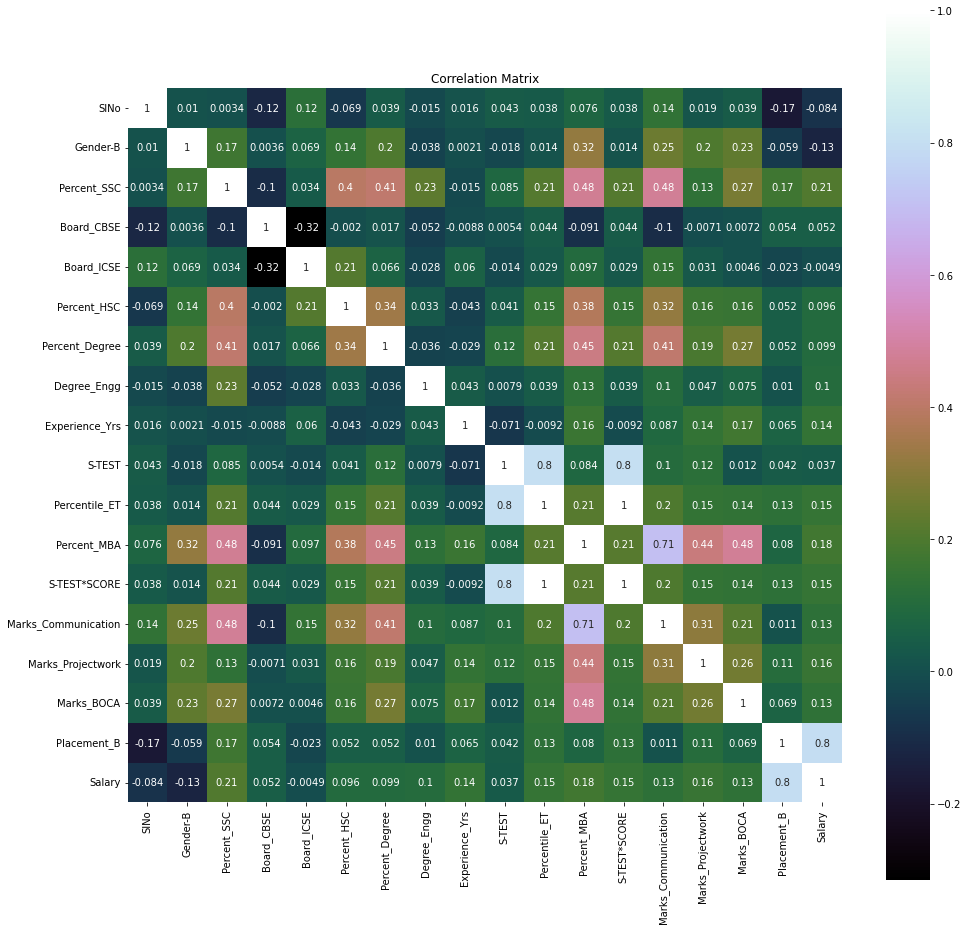

In [7]:
# Placement rate
n_employees = len(data)
print(data.Placement.value_counts())
print(data.Placement.value_counts()/n_employees*100)

# Histograms
#data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12)) # bins=50
#plt.show()

# Correlations
corr_matrix = data.corr()
plt.figure(figsize=(16,16))
plt.title('Correlation Matrix')
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.show()

In [9]:
# Set the target and features
# Choose the dependent variable column "Placement" and set it as target
target = data.Placement_B

# Drop column churn and set everything else as features
#features = data.drop("Placement_B",axis=1)
#features = data.drop("SlNo",axis=1)
features = data[["Percentile_ET", "S-TEST*SCORE",
                 "Percent_SSC", "Percent_HSC",
                 "Marks_Communication", "Marks_BOCA",
                 "Experience_Yrs", "Percent_Degree",
                 "Degree_Engg","Board_ICSE"]]

# Use that function to create the splits both for target and for features
# Set the test sample to be 25% of your observations
y_train, y_test, x_train, x_test = train_test_split(target,features,test_size=0.25, random_state=42) # random_state=42

In [10]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# Neural Network
models.append(('NN', MLPClassifier()))
# Ensemble Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))
models.append(('ET', ExtraTreesClassifier()))

In [11]:
# K-folds cross validation
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

# Test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.795287 (0.029594)
LDA: 0.795287 (0.029594)
KNN: 0.785057 (0.049989)
CART: 0.668391 (0.084722)
NB: 0.744368 (0.059155)
NN: 0.774828 (0.037077)
AB: 0.737126 (0.040775)
GBM: 0.754253 (0.039850)
RF: 0.778161 (0.046360)
ET: 0.781724 (0.050148)


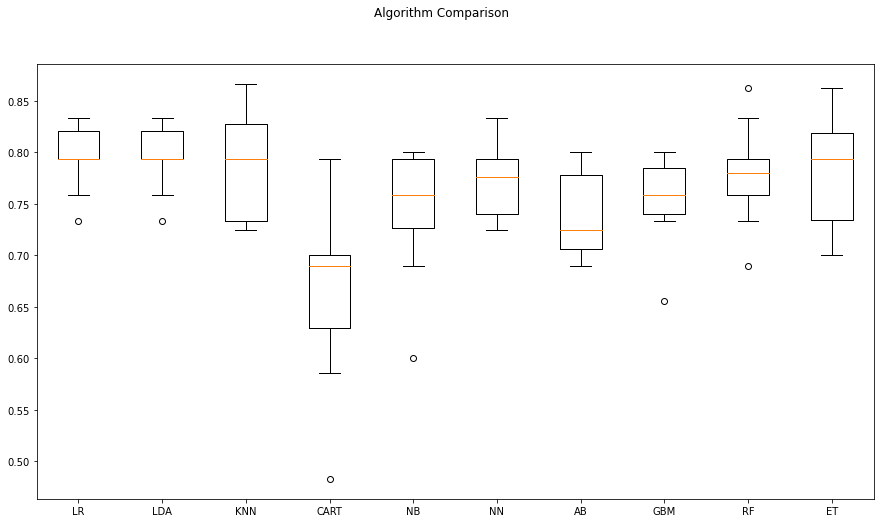

In [12]:
# Compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

In [15]:
model = MLPClassifier()
model.fit(x_train, y_train)

MLPClassifier()

In [16]:
predictions = model.predict(x_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.81      1.00      0.89        79

    accuracy                           0.81        98
   macro avg       0.40      0.50      0.45        98
weighted avg       0.65      0.81      0.72        98

[[ 0 19]
 [ 0 79]]
